In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Creating an engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declaring a Base using `automap_base()`
Base = automap_base()
# Reflecting the database tables using the base class
Base.prepare(autoload_with = engine)


In [6]:
# Printing all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assigning the classes `measurement` and `station` to a variable called `Measurement`
# and `Station` respectively
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Creating a session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

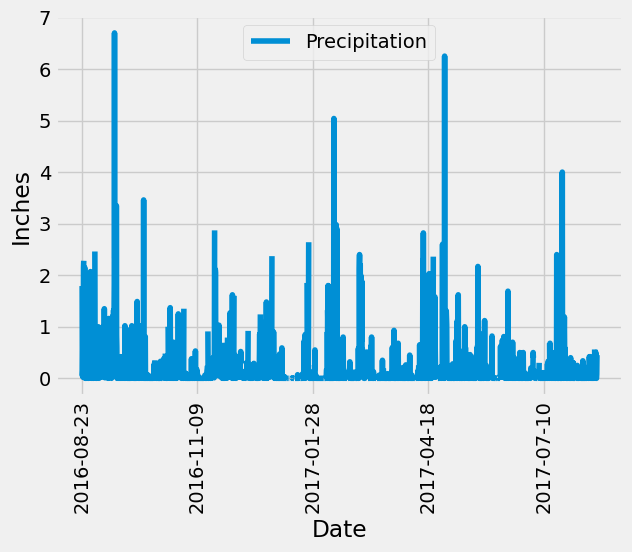

In [10]:
# Calculating the date one year from the last date in data set.
past_year_date = dt.date(2017,8,23)-dt.timedelta(days = 365 )

#  A query to retrieve the date and precipitation scores for one year before the last date.
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_year_date)

# Saving the data retrieved from previous query as a Pandas DataFrame and seting the column names.
data_df = pd.DataFrame(data, columns=["Date", "Precipitation"])

# Sorting the dataframe by date.
sorted_data_df = data_df.sort_values(by="Date")

# Plotting with Matplotlib to plot the sorted data.
sorted_data_df.plot(x="Date",y="Precipitation")
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel('Inches')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [11]:
# Summary statistics for the precipitation data using pandas agg function.
agg_stat_summary = sorted_data_df["Precipitation"].agg(
    count='count', 
    mean='mean', 
    std='std', 
    min='min', 
    **{'25%' : lambda x: x.quantile(0.25)},
    **{'50%' : lambda x: x.quantile(0.50)},
    **{'75%' : lambda x: x.quantile(0.75)},
    max = 'max'
)
pd.DataFrame(agg_stat_summary)


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# A query to calculate the total number of stations in the dataset.
count_station = session.query(Station.station).count()
count_station

9

In [13]:
# A query to find the most active stations (i.e. which stations have the most rows?)
# and listing the stations and their counts in descending order.
sel = [Station.station,
       func.count(Measurement.station)]
session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Calculating the lowest, highest, and average temperature for the most active station id from the previous query.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Station.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

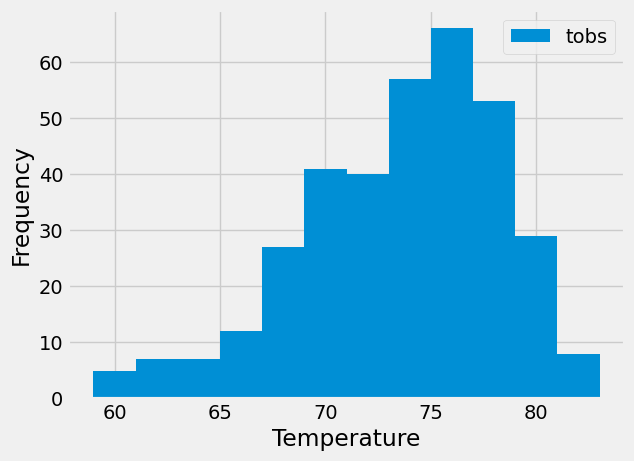

In [15]:
# From the most active station id
# we have below the query for the last 12 months of temperature observation data for this station and 
# ploting the results as a histogram
data_temp = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
temperature = [temp[0] for temp in data_temp]
temperature
plt.hist(temperature,bins=12,label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [16]:
# Closing Session
session.close()
